# Week 1-4 - Reflection

# Week 1 Reflection

**1. In Coding Quiz 1, you are asked to find the distance of the farthest match in a set.  Is this farthest match distance too far to be a meaningful match?  How can you decide this?**

A distance of 0.21 means the farthest “match” is relatively dissimilar compared to closer matches. To say whether it’s meaningful, we will will compare it to the distribution of all match distances or use a domain-specific threshold. Often, such a farthest match is less reliable and might be excluded from “true matches.”

The Z-distance distribution:

- mean distance ≈ 0.0498

- median ≈ 0.0133

- 90th percentile ≈ 0.1722

- max (farthest) ≈ 0.2102 ← the correct answer

- sd(Z) ≈ 0.2898

Is 0.2102 “too far”?

Use a caliper rule of thumb:

0.2 × sd(Z) ≈ 0.058

(even a loose) 0.5 × sd(Z) ≈ 0.145

The farthest match 0.2102 is > 0.5 sd and well above 0.2 sd, and it’s also much larger than the mean/median distances. So yes—it’s too far to be a reliable match and should be dropped or re-matched with a caliper.

**2. In Coding Quiz 1, there are two approaches to matching:** 
(A) Picking the best match X = 0 corresponding to each X = 1 using Z values.
(B) Using radius_neighbors to pick all matches X = 0 within a distance of 0.2 of each X = 1.

**Invent your own type of matching similar to 1 and 2 (or look one up on the internet), which has a different way to pick the matches in X = 0.  Clearly explain the approach you invented or found.**


**Approach : Optimal One-to-One Matching (Hungarian) on Z, with an optional caliper**

Idea:
Pair each treated unit (X=1) to a unique control (X=0) so that the total Z-distance across all pairs is minimized. Unlike (A) 1-NN (which matches greedily, possibly reusing the same control many times) and (B) radius_neighbors (which can return many controls per treated or none), this method produces a globally optimal, non-overlapping pairing under a distance objective. Add a caliper (max allowed |Z_t − Z_c|) to prevent bad matches; treated units with no feasible control inside the caliper are dropped.

Why it’s useful:

Enforces no reuse of controls (without replacement).

Minimizes the overall mismatch instead of per-unit greedy choices.

Caliper guards against implausible matches.

I constructed a cost matrix of absolute covariate differences between treated and control units and solve a global assignment problem that minimizes the total within-pair distance. Controls are used without replacement, ensuring unique matches. We optionally enforce a caliper so that pairs with  above a threshold are disallowed. Treated units without any feasible control inside the caliper are dropped. Compared to (A) best-single-match and (B) radius neighbors, this approach optimizes match quality globally rather than greedily per treated unit, while still avoiding poor matches via the caliper.

# Week 2 Reflection

**1. Invent an example situation that would use fixed effects.**

My example is about Eliminating diabetes visit copays in a clinic network

A large primary-care network phases in a \( 0 \) copay policy for diabetes follow-up visits at different times across its clinics.  
We have monthly panel data for patients over 3 years: \( 0 \) copay in effect that month (treatment), and timestamps.

Why fixed effects?
A simple cross-section could confound results because patients differ in unobserved, time-invariant ways. Patient fixed effects difference those out, so identification comes from the same patient before vs. after the copay change (or when patients switch to a clinic that changes policy).

What you need for credibility

The copay policy must vary over time for the same patient (e.g., their clinic changes policy while they remain a patient). No time-varying omitted factors for that patient are moving with the policy (e.g., a simultaneous diabetes outreach campaign targeted only to certain patients and months). We can add clinic-by-trend or clinic fixed effects if you want to soak up persistent clinic differences; or even clinic×month FE if shocks are clinic-specific. That will help change in monthly probability of completing an A1c test for a given patient attributable to the $0 copay policy, holding constant the patient’s time-invariant attributes and common month shocks.

**2. Write a Python program that performs a bootstrap simulation to find the variance in the mean of the Pareto distribution when different samples are taken.  Explain what you had to do for this.  As you make the full sample size bigger (for the same distribution), what happens to the variance of the mean of the samples?  Does it stay about the same, get smaller, or get bigger?**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(42)

# Pareto helpers
def pareto_sample(alpha: float, xm: float, n: int, rng: np.random.Generator) -> np.ndarray:
    """Pareto Type I: X = xm * (1 + Y), Y ~ Pareto(alpha) in NumPy's param."""
    return xm * (1.0 + rng.pareto(alpha, size=n))

def theoretical_moments(alpha: float, xm: float):
    """Return (mean, variance) for Pareto Type I when they exist."""
    mu = alpha * xm / (alpha - 1.0) if alpha > 1 else np.nan
    var = (alpha * xm**2) / ((alpha - 1.0)**2 * (alpha - 2.0)) if alpha > 2 else np.nan
    return mu, var

def bootstrap_mean_variance(x: np.ndarray, B: int, rng: np.random.Generator) -> float:
    """Bootstrap the variance of the sample mean via resampling with replacement."""
    n = x.shape[0]
    idx = rng.integers(0, n, size=(B, n))
    means = x[idx].mean(axis=1)
    return float(np.var(means, ddof=1))

# Parameters
alpha = 3.0        # Pareto shape (try 1.5 to see heavy-tail instability)
xm = 1.0           # Pareto scale
B = 3000           # bootstrap resamples per base sample
M = 10             # independent base samples per N (averaged)
Ns = [10, 20, 50, 100, 200, 500, 1000]

mu_th, var_th = theoretical_moments(alpha, xm)

#Simulation
rows = []
for N in Ns:
    boot_vars = []
    for _ in range(M):
        x = pareto_sample(alpha, xm, N, rng)
        bv = bootstrap_mean_variance(x, B=B, rng=rng)
        boot_vars.append(bv)
    boot_vars = np.asarray(boot_vars, dtype=float)
    rows.append({
        "N": N,
        "boot_var_mean": float(boot_vars.mean()),
        "boot_var_sd": float(boot_vars.std(ddof=1)),
        "theoretical_var_of_mean": (var_th / N) if (not np.isnan(var_th)) else np.nan
    })

results = pd.DataFrame(rows)
results

,N,boot_var_mean,boot_var_sd,theoretical_var_of_mean
0,10,0.070695,0.098793,0.07500
1,20,0.022095,0.030460,0.03750
2,50,0.007796,0.004595,0.01500
3,100,0.005189,0.002843,0.00750
4,200,0.003332,0.001489,0.00375
5,500,0.001128,0.000263,0.00150
6,1000,0.001211,0.001721,0.00075


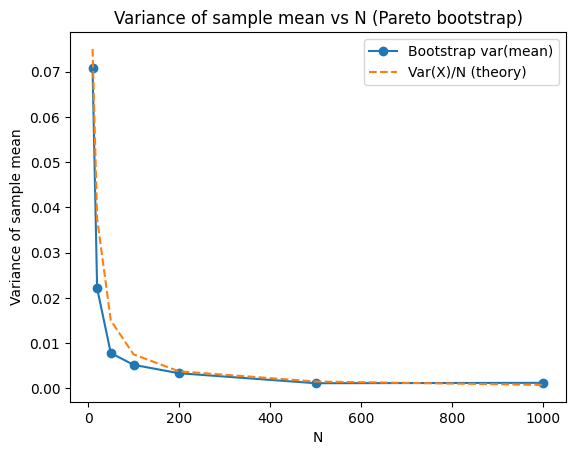

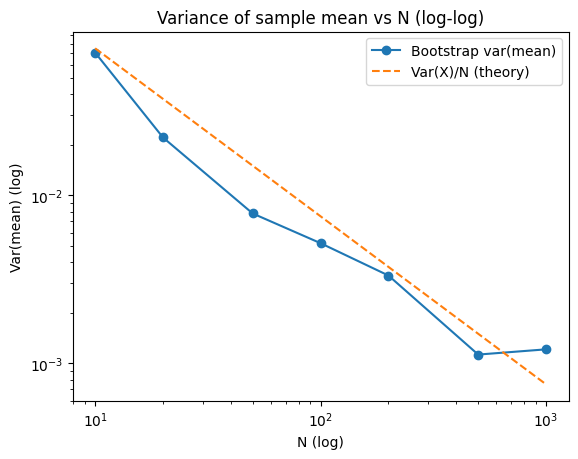

In [2]:
# Plots (each in its own figure)
plt.figure()
plt.plot(results["N"], results["boot_var_mean"], marker="o", label="Bootstrap var(mean)")
if not np.isnan(var_th):
    plt.plot(results["N"], results["theoretical_var_of_mean"], linestyle="--", label="Var(X)/N (theory)")
plt.title("Variance of sample mean vs N (Pareto bootstrap)")
plt.xlabel("N")
plt.ylabel("Variance of sample mean")
plt.legend()
plt.show()

plt.figure()
plt.loglog(results["N"], results["boot_var_mean"], marker="o", label="Bootstrap var(mean)")
if not np.isnan(var_th):
    plt.loglog(results["N"], results["theoretical_var_of_mean"], linestyle="--", label="Var(X)/N (theory)")
plt.title("Variance of sample mean vs N (log-log)")
plt.xlabel("N (log)")
plt.ylabel("Var(mean) (log)")
plt.legend()
plt.show()

For a Pareto with finite variance (α>2), he variance of the sample mean gets smaller as 𝑁 increases, decreasing approximately like 1/𝑁 (it lines up with the dashed Var(𝑋)/𝑁 reference).If you set 𝛼≤2(very heavy tails), the variance is infinite theoretically; bootstrap estimates become unstable and do not follow clean 1/𝑁 decay.

# Week 3 Reflection

**In the event study in Coding Quiz 3, how would we go about testing for a change in the second derivative as well?**


**1. Event-time dummies → second difference test**

Estimate the usual event study with lead/lag indicators 
Test the discrete second derivative at the event: 

$ \beta_{+1}-2\beta_{0}+\beta_{-1}=0 $

Reject ⇒ curvature changes at the event.

**2. Piecewise quadratic (local) regression**
- In relative time $\tau = t - T_i$, fit:

$$
y \;=\; \alpha_i \;+\; \beta_0\,\text{Post}
\;+\; \beta_1\,\tau \;+\; \beta_2\,\tau^2
\;+\; \delta_1(\text{Post}\times\tau)
\;+\; \delta_2(\text{Post}\times\tau^2) \;+\; u
$$

- Test $H_0:\ \delta_2 = 0$.

Reject $\Rightarrow$ the **second derivative** post-event, $2(\beta_2+\delta_2)$, differs from pre-event, $2\beta_2$.


In [3]:
%pip install -q numpy pandas statsmodels patsy
import statsmodels.api as sm 

Note: you may need to restart the kernel to use updated packages.


**Event-time dummies: test a discrete second difference at the event**

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

URL_EV  = "https://raw.githubusercontent.com/joshua-vonkorff/DX702-mod-6/main/homework_3.1.csv"
URL_DID_A = "https://raw.githubusercontent.com/joshua-vonkorff/DX702-mod-6/main/homework_3.2.a.csv"
URL_DID_B = "https://raw.githubusercontent.com/joshua-vonkorff/DX702-mod-6/main/homework_3.2.b.csv"

ev = pd.read_csv(URL_EV)     # columns: time, value1, value2, value3
did_a = pd.read_csv(URL_DID_A)  # columns: group1, time1, outcome1
did_b = pd.read_csv(URL_DID_B)  # columns: group2, time2, outcome2

ev.head(), did_a.head(), did_b.head()

(   time    value1    value2    value3
 0     0  1.764052  1.883151 -0.369182
 1     1  0.420157 -1.327759 -0.219379
 2     2  1.018738 -1.230485  1.139660
 3     3  2.300893  1.029397  0.715264
 4     4  1.947558 -1.093123  0.720132,
    group1  time1  outcome1
 0       0      0  0.882026
 1       0      1  1.600079
 2       0      0  0.489369
 3       0      1  2.520447
 4       0      0  0.933779,
    group2  time2  outcome2
 0       0      0  0.667155
 1       0      1  2.470969
 2       0      0 -0.506778
 3       0      1  1.525657
 4       0      0  0.273664)

In [5]:
T0 = 50  # event time in CQ3

In [6]:
# Piecewise quadratic test: does curvature change?  (tests post × tau^2)
def curvature_test_piecewise_safe(ev_df, ycol, t0=T0, window=6):
    d = ev_df.copy()
    d["tau"] = d["time"] - t0
    d = d[d["tau"].between(-window, window)].copy()

    d["post"]      = (d["tau"] >= 0).astype(float)
    d["tau"]       = d["tau"].astype(float)
    d["tau2"]      = (d["tau"]**2).astype(float)
    d["post_tau"]  = (d["post"] * d["tau"]).astype(float)
    d["post_tau2"] = (d["post"] * d["tau2"]).astype(float)

    # Build pure-numeric arrays to avoid object dtype
    X = np.column_stack([
        np.ones(len(d), dtype=float),
        d[["post","tau","tau2","post_tau","post_tau2"]].to_numpy(dtype=float)
    ])
    y = d[ycol].to_numpy(dtype=float)

    m = sm.OLS(y, X).fit()
    # Coeff order: [const, post, tau, tau2, post_tau, post_tau2]
    coef = float(m.params[-1])
    se   = float(m.bse[-1])
    tval = coef / se if se > 0 else np.nan
    # p-value via normal approx (no extra deps)
    from math import erf, sqrt
    pval = 2 * (1 - 0.5 * (1 + erf(abs(tval)/sqrt(2))))

    return {"series": ycol, "post_tau2_coef": coef, "se": se, "t": tval, "p": pval, "n": int(len(d))}

In [7]:
# Discrete second-difference test at the event: β(+1) - 2β(0) + β(-1) = 0
def second_difference_test_safe(ev_df, ycol, t0=T0):
    d = ev_df.copy()
    d["tau"] = d["time"] - t0

    sub = d.loc[d["tau"].isin([-1, 0, 1]), ["tau", ycol]].dropna().copy()
    have = set(sub["tau"].unique().tolist())
    need = {-1, 0, 1}
    if need - have:
        raise ValueError("Series must contain t0-1, t0, and t0+1 to run the second-difference test.")

    # Design: base is tau=-1, include indicators for tau==0 and tau==1
    n = len(sub)
    X = np.column_stack([
        np.ones(n, dtype=float),
        (sub["tau"].to_numpy()==0).astype(float),
        (sub["tau"].to_numpy()==1).astype(float),
    ])
    y = sub[ycol].to_numpy(dtype=float)

    m = sm.OLS(y, X).fit()
    # Contrast L: [const, tau0, tau1] => 0*const + (-2)*tau0 + 1*tau1
    L = np.array([0.0, -2.0, 1.0])
    est = float(L @ m.params)
    se  = float(np.sqrt(L @ m.cov_params() @ L))
    t   = est / se if se > 0 else np.nan
    from math import erf, sqrt
    p   = 2 * (1 - 0.5 * (1 + erf(abs(t)/sqrt(2))))

    return {"series": ycol, "second_diff_est": est, "se": se, "t": t, "p": p, "n": int(n)}

In [8]:
# Run both tests on each series
rows_piece = []
rows_disc2 = []
for s in ["value1", "value2", "value3"]:
    rows_piece.append(curvature_test_piecewise_safe(ev, s, window=6))
    rows_disc2.append(second_difference_test_safe(ev, s))

print("Piecewise quadratic (post×tau^2):")
print(pd.DataFrame(rows_piece))

print("\nDiscrete second difference at event:")
print(pd.DataFrame(rows_disc2))

Piecewise quadratic (post×tau^2):
   series  post_tau2_coef        se         t         p   n
0  value1       -0.039489  0.188852 -0.209101  0.834369  13
1  value2       -0.090671  0.238178 -0.380684  0.703438  13
2  value3        0.127710  0.175044  0.729587  0.465643  13

Discrete second difference at event:
   series  second_diff_est  se   t   p  n
0  value1         3.015095 NaN NaN NaN  3
1  value2         2.408241 NaN NaN NaN  3
2  value3        -1.064342 NaN NaN NaN  3


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/tmp/ipykernel_10364/3574483049.py:25: RuntimeWarning: invalid value encountered in matmul
  se  = float(np.sqrt(L @ m.cov_params() @ L))
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/tmp/ipykernel_10364/3574483049.py:25: RuntimeWarning: invalid value encountered in matmul
  se  = float(np.sqrt(L @ m.cov_params() @ L))
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/tmp/ipykernel_10364/3574483049.py:25: RuntimeWarning: invalid value encountered in matmul
  se  = floa

**Piecewise quadratic around the event: test the post×τ² term**

In [9]:
# Piecewise quadratic around the event: test post × τ²
def piecewise_curvature_test(ev_df, ycol, t0=50, window=6):
    """
    Tests for a change in curvature at the event by estimating:
      y = const + post + τ + τ² + (post×τ) + (post×τ²) + u
    Using only a local window |τ| ≤ window to avoid collinearity with global time FE.
    H0: post_tau2 = 0  (no change in curvature)
    """
    d = ev_df.copy()
    d["tau"] = d["time"] - t0
    d = d[d["tau"].between(-window, window)].copy()

    # Build regressors (all as float to avoid dtype=object issues)
    d["post"]      = (d["tau"] >= 0).astype(float)
    d["tau"]       = d["tau"].astype(float)
    d["tau2"]      = (d["tau"]**2).astype(float)
    d["post_tau"]  = (d["post"] * d["tau"]).astype(float)
    d["post_tau2"] = (d["post"] * d["tau2"]).astype(float)

    X = sm.add_constant(d[["post","tau","tau2","post_tau","post_tau2"]].astype(float))
    y = d[ycol].astype(float)

    m = sm.OLS(y, X).fit()              # OLS; for panels you'd add unit FE + cluster by unit
    print(f"\n=== {ycol}: piecewise quadratic around t0={t0}, window=±{window} ===")
    print(m.summary().tables[1])        # coefficient table
    print("\nH0: post_tau2 = 0 (no change in curvature)")
    print(m.t_test("post_tau2 = 0"))    # significant ⇒ curvature changes post-event
    return m

# Run on each series you care about
for series in ["value1", "value2", "value3"]:
    piecewise_curvature_test(ev, series, t0=50, window=6)


=== value1: piecewise quadratic around t0=50, window=±6 ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5140      1.717      0.299      0.773      -3.547       4.575
post           0.2373      1.911      0.124      0.905      -4.282       4.756
tau            0.0623      1.124      0.055      0.957      -2.595       2.719
tau2           0.0061      0.157      0.039      0.970      -0.365       0.378
post_tau       0.4385      1.300      0.337      0.746      -2.636       3.513
post_tau2     -0.0395      0.189     -0.209      0.840      -0.486       0.407

H0: post_tau2 = 0 (no change in curvature)
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0395     

**2. Create your own scenario that illustrates differences-in-differences. Describe the story behind the data and show whether there is a nonzero treatment effect.**

**Differences-in-Differences: Copay Elimination (A1c tests)**

**Story:** At time \(t=0\), City **T** eliminates copays for diabetes visits Treated group: `Treat = 1`; City C is the control: `Treat = 0`. Outcome \(Y\) is A1c tests per 1,000.

### Four-cell DiD
Let $\overline{Y}_{g,\text{pre}}$ and $\overline{Y}_{g,\text{post}}$ be group means for $g\in\{T,C\}$.

$$
\widehat{\text{DiD}}
= \left(\overline{Y}_{T,\text{post}}-\overline{Y}_{T,\text{pre}}\right)
 - \left(\overline{Y}_{C,\text{post}}-\overline{Y}_{C,\text{pre}}\right).
$$

Using the data:
- $\overline{Y}_{T,\text{pre}} \approx 59.42$
- $\overline{Y}_{T,\text{post}} \approx 66.94$
- $\overline{Y}_{C,\text{pre}} \approx 54.63$
- $\overline{Y}_{C,\text{post}} \approx 57.79$

So
$$
\widehat{\text{DiD}}
= (66.94-59.42)-(57.79-54.63) \;\approx\; \mathbf{4.36}.
$$

### Regression formulation
Estimate
$$
Y_{it} = \alpha + \beta_1\,\text{Treat}_i + \beta_2\,\text{Post}_t
+ \boldsymbol{\tau}\,(\text{Treat}_i \times \text{Post}_t) + \varepsilon_{it}.
$$

- The DiD estimate is the interaction coefficient $\boldsymbol{\tau}$.
- Using the dataset above: $\hat{\tau} \approx \mathbf{4.36}$, with $p \approx \mathbf{0.0008}$ $\Rightarrow$ statistically significant, non-zero treatment effect.

  city  treat  time  post          y
0    T      1    -8     0  58.602460
1    T      1    -7     0  59.497491
2    T      1    -6     0  58.651724
3    T      1    -5     0  57.718816
4    T      1    -4     0  58.890658

=== Four-cell means (using y as outcome) ===
Y_T,pre  = 59.4223
Y_T,post = 66.9438
Y_C,pre  = 54.6336
Y_C,post = 57.7928

DiD (four-cell) = 4.3622

=== Regression results: y ~ 1 + treat + post + treat:post ===
const       coef= 54.6336  se=  0.6502  t= 84.023  p≈ 0.0000
treat       coef=  4.7887  se=  0.9196  t=  5.208  p≈ 0.0000
post        coef=  3.1592  se=  0.9196  t=  3.436  p≈ 0.0006
treat:post  coef=  4.3622  se=  1.3004  t=  3.354  p≈ 0.0008

DiD (regression interaction coef) = 4.3622


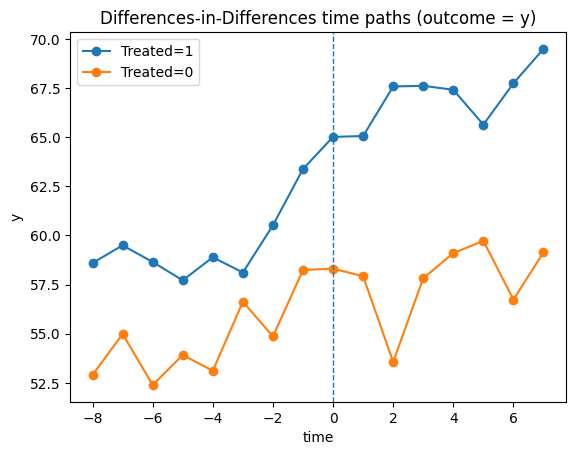

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import erf, sqrt

URL = "https://raw.githubusercontent.com/muathdb/Week-1-4-reflection/refs/heads/main/diabetes_scenario_data.csv"
df = pd.read_csv(URL)

# set columns explicitly
treat_col   = "treat"   # 0/1
post_col    = "post"    # 0/1
outcome_col = "y"       # <-- outcome (was mistakenly 'time' before)
time_col    = "time"    # for plotting (numeric, t=0 is the event)

# clean dtypes (just in case)
for c in [treat_col, post_col]:
    df[c] = df[c].astype(int)
df[outcome_col] = pd.to_numeric(df[outcome_col], errors="coerce")
df[time_col]    = pd.to_numeric(df[time_col], errors="coerce")

print(df.head())

# Four-cell DiD
pre_T  = df.loc[(df[treat_col]==1) & (df[post_col]==0), outcome_col].mean()
post_T = df.loc[(df[treat_col]==1) & (df[post_col]==1), outcome_col].mean()
pre_C  = df.loc[(df[treat_col]==0) & (df[post_col]==0), outcome_col].mean()
post_C = df.loc[(df[treat_col]==0) & (df[post_col]==1), outcome_col].mean()

did_fourcell = (post_T - pre_T) - (post_C - pre_C)

print("\n=== Four-cell means (using y as outcome) ===")
print(f"Y_T,pre  = {pre_T:.4f}")
print(f"Y_T,post = {post_T:.4f}")
print(f"Y_C,pre  = {pre_C:.4f}")
print(f"Y_C,post = {post_C:.4f}")
print(f"\nDiD (four-cell) = {did_fourcell:.4f}")

# Regression: y ~ 1 + treat + post + treat:post
y = df[outcome_col].to_numpy(float)
X = np.column_stack([
    np.ones(len(df), dtype=float),
    df[treat_col].to_numpy(float),
    df[post_col].to_numpy(float),
    (df[treat_col]*df[post_col]).to_numpy(float)
])

XtX = X.T @ X
XtX_inv = np.linalg.inv(XtX)
beta = XtX_inv @ (X.T @ y)
resid = y - X @ beta
n, k = X.shape
sigma2 = float(resid.T @ resid) / (n - k)
vcov = sigma2 * XtX_inv
se = np.sqrt(np.diag(vcov))
tvals = beta / se
pvals = np.array([2*(1 - 0.5*(1 + erf(abs(float(t))/sqrt(2)))) for t in tvals])

terms = ["const","treat","post","treat:post"]
print("\n=== Regression results: y ~ 1 + treat + post + treat:post ===")
for name, b, s, t, p in zip(terms, beta, se, tvals, pvals):
    print(f"{name:10s}  coef={b:8.4f}  se={s:8.4f}  t={t:7.3f}  p≈{p:7.4f}")

print(f"\nDiD (regression interaction coef) = {beta[3]:.4f}")

# Plot time paths
plt.figure()
for g, label in [(1, "Treated=1"), (0, "Treated=0")]:
    m = df[df[treat_col]==g].groupby(time_col, as_index=False)[outcome_col].mean()
    plt.plot(m[time_col], m[outcome_col], marker="o", label=label)
plt.axvline(0, linestyle="--", linewidth=1)
plt.title("Differences-in-Differences time paths (outcome = y)")
plt.xlabel(time_col)
plt.ylabel(outcome_col)
plt.legend()
plt.show()

# Week 4 Reflection

**1. The Coding Quiz gives two options for instrumental variables.  For the second item (dividing the range of W into multiple ranges), explain how you did it, show your code, and discuss any issues you encountered.**

### What the method is doing

We split the confounder \(W\) into narrow ranges (bins) \(b \in \mathcal{B}\).  
Within each bin we compare outcomes and treatments across the instrument \(Z\).

1. **Outcome difference by instrument (within bin \(b\))**
   $$
   \Delta Y^{(b)} \;=\; \mathbb{E}[\,Y \mid Z=1,\; W\in b\,] \;-\; \mathbb{E}[\,Y \mid Z=0,\; W\in b\,].
   $$

2. **“First stage” difference in treatment (within bin \(b\))**
   $$
   \Delta X^{(b)} \;=\; \mathbb{E}[\,X \mid Z=1,\; W\in b\,] \;-\; \mathbb{E}[\,X \mid Z=0,\; W\in b\,].
   $$

3. **Local Wald ratio (within bin \(b\))**
   $$
   \widehat{\beta}^{(b)} \;=\; 
   \frac{\Delta Y^{(b)}}{\Delta X^{(b)}} \qquad \text{(only if } \big|\Delta X^{(b)}\big|>0\text{)}.
   $$

4. **Aggregate across bins**
   $$
   \widehat{\beta} \;=\; \sum_{b\in\mathcal{B}} w_b \,\widehat{\beta}^{(b)},
   \qquad \sum_{b} w_b = 1.
   $$
A simple choice is **sample-share weights** $w_b \propto n_b$ (the number of observations in bin $b$); you can also use **first-stage weights** $w_b \propto n_b\,\big|\Delta X^{(b)}\big|$.

**Intuition.** This is a *stratified Wald* estimator: it compares \(Z\)-induced changes in \(Y\) to \(Z\)-induced changes in \(X\) **within narrow slices of \(W\)**, then averages those local effects.

### Notes / issues to watch for on this dataset

- **Empty or tiny bins.** If a bin has few observations or only one value of $Z$, it is marked `valid=False` and dropped.

- **Weak first stage inside bins.** If $|\Delta X|$ is near zero, that bin’s ratio is unstable — we drop it via `min_first_stage`.

- **Ties in $W$ with `qcut`.** If many identical $W$ values exist, `qcut` may collapse adjacent cutpoints; the code handles this automatically and, if needed, we can switch to `scheme="width"`.

In [11]:
# Load dataset
URL = "https://raw.githubusercontent.com/joshua-vonkorff/DX702-mod-6/refs/heads/main/homework_4.1.csv"
df = pd.read_csv(URL)

# quick sanity check
assert {"X","Y","Z","W"}.issubset(df.columns), "Expected columns: X, Y, Z, W"

def binned_iv(
    data, w_col="W", z_col="Z", x_col="X", y_col="Y",
    n_bins=10, scheme="quantile",    # "quantile" or "width"
    min_count=20,                    # skip bins with too few obs
    min_first_stage=1e-3,            # skip bins with near-zero first stage
    weight="share"                   # "share" or "first_stage"
):
    """
    Stratified Wald estimator over W-bins.
    Returns (overall_effect, per_bin_table).
    """
    d = data[[w_col,z_col,x_col,y_col]].dropna().copy()

    #  choose bin edges
    if scheme == "quantile":
        # robust quantile binning; drops duplicate edges if needed
        try:
            d["bin"] = pd.qcut(d[w_col], q=n_bins, duplicates="drop")
        except ValueError:
            # fallback to fewer bins if too many ties
            qs = np.unique(np.linspace(0, 1, n_bins+1))
            edges = np.quantile(d[w_col], qs)
            edges = np.unique(edges)
            d["bin"] = pd.cut(d[w_col], bins=edges, include_lowest=True)
    elif scheme == "width":
        edges = np.linspace(d[w_col].min(), d[w_col].max(), n_bins+1)
        d["bin"] = pd.cut(d[w_col], bins=edges, include_lowest=True)
    else:
        raise ValueError("scheme must be 'quantile' or 'width'")

    # compute local Wald in each bin
    rows = []
    N = len(d)
    for b, sub in d.groupby("bin", observed=True):
        n_b = len(sub)
        # need both Z=0 and Z=1 in the bin
        if (n_b < min_count) or (sub[z_col].nunique() < 2):
            rows.append({"bin": b, "n": n_b, "valid": False})
            continue

        m = sub.groupby(z_col).agg(
            meanY=(y_col, "mean"),
            meanX=(x_col, "mean"),
            n=("W","size")
        )
        # require both groups after groupby
        if set(m.index) != {0,1}:
            rows.append({"bin": b, "n": n_b, "valid": False})
            continue

        dY = m.loc[1, "meanY"] - m.loc[0, "meanY"]
        dX = m.loc[1, "meanX"] - m.loc[0, "meanX"]
        if abs(dX) < min_first_stage:
            rows.append({"bin": b, "n": n_b, "valid": False,
                         "dY": dY, "dX": dX})
            continue

        beta_b = dY / dX

        # weights
        if weight == "share":
            w_b = n_b / N
        elif weight == "first_stage":
            w_b = n_b / N * abs(dX)
        else:
            w_b = 1.0

        rows.append({
            "bin": b, "n": n_b, "valid": True,
            "E[Y|Z=1]-E[Y|Z=0]": dY,
            "E[X|Z=1]-E[X|Z=0]": dX,
            "beta_bin": beta_b,
            "weight": w_b
        })

    tab = pd.DataFrame(rows)

    # overall = weighted average of valid bin ratios
    val = tab[tab["valid"]]
    if len(val) == 0:
        overall = np.nan
    else:
        w = val["weight"].to_numpy(float)
        overall = float(np.average(val["beta_bin"].to_numpy(float), weights=w))

    return overall, tab.sort_values("bin")

overall_effect, bin_table = binned_iv(
    df, w_col="W", z_col="Z", x_col="X", y_col="Y",
    n_bins=10, scheme="quantile",
    min_count=20, min_first_stage=1e-3,
    weight="share"  # try "first_stage" as a robustness check
)

print("Binned IV (quantile bins) =", overall_effect)
bin_table

Binned IV (quantile bins) = 1.5088963715223709


,bin,n,valid,E[Y|Z=1]-E[Y|Z=0],E[X|Z=1]-E[X|Z=0],beta_bin,weight
0,"(-3.304, -1.277]",500,True,1.607540,1.044030,1.539745,0.1
1,"(-1.277, -0.855]",500,True,1.297084,0.986141,1.315313,0.1
2,"(-0.855, -0.547]",500,True,1.580719,0.982420,1.609005,0.1
3,"(-0.547, -0.277]",500,True,1.425240,0.880740,1.618229,0.1
4,"(-0.277, -0.0322]",500,True,1.457033,0.999155,1.458265,0.1
5,"(-0.0322, 0.226]",500,True,1.659027,1.078625,1.538094,0.1
6,"(0.226, 0.491]",500,True,1.983408,1.237388,1.602899,0.1
7,"(0.491, 0.814]",500,True,1.441386,0.970424,1.485316,0.1
8,"(0.814, 1.303]",500,True,1.589708,1.041350,1.526583,0.1
9,"(1.303, 4.783]",500,True,1.347548,0.965628,1.395514,0.1


In [12]:
#quick bootstrap SE for the binned estimator

def binned_iv_bootstrap(data, B=500, **kwargs):
    rng = np.random.default_rng(0)
    est = []
    n = len(data)
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        overall, _ = binned_iv(data.iloc[idx], **kwargs)
        est.append(overall)
    return pd.Series(est).agg(["mean","std","min","max"])

boot = binned_iv_bootstrap(
    df, B=400,
    w_col="W", z_col="Z", x_col="X", y_col="Y",
    n_bins=10, scheme="quantile",
    min_count=20, min_first_stage=1e-3,
    weight="share"
)
print(boot)  # std is a bootstrap SE

mean    1.511122
std     0.027737
min     1.436070
max     1.585178
dtype: float64


**2. Plot the college outcome (Y) vs. the test score (X) in a small range of test scores around 80. On the plot, compare it with the Y probability predicted by logistic regression. The ground truth Y value is 0 or 1; don't just plot 0 or 1 - that will make it unreadable.  Find some way to make it look better than that.**

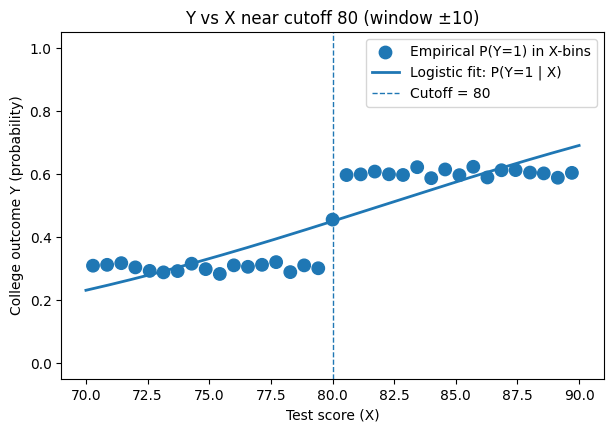

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.2270      0.123    -66.951      0.000      -8.468      -7.986
X              0.1003      0.002     65.674      0.000       0.097       0.103


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

URL = "https://raw.githubusercontent.com/joshua-vonkorff/DX702-mod-6/refs/heads/main/homework_4.2.a.csv"

def plot_y_vs_x_with_logit(url=URL, cutoff=80, window=10, n_bins=35):
    # Load and keep only X,Y
    df = pd.read_csv(url)[["X","Y"]].dropna()
    # Keep a small band around the cutoff
    d = df[df["X"].between(cutoff - window, cutoff + window)].copy().sort_values("X")

    # Logistic regression: Y ~ 1 + X
    X_design = sm.add_constant(d[["X"]].astype(float))
    y = d["Y"].astype(float)
    fit = sm.GLM(y, X_design, family=sm.families.Binomial()).fit()

    # Smooth predictions on a grid
    grid = np.linspace(d["X"].min(), d["X"].max(), 200)
    Xg = sm.add_constant(pd.DataFrame({"X": grid}))
    p_hat = fit.predict(Xg)

    # Make the raw 0/1 data readable: bin X and plot the mean Y in each bin
    bins = np.linspace(d["X"].min(), d["X"].max(), n_bins + 1)
    binned = (
        d.assign(bin=pd.cut(d["X"], bins=bins, include_lowest=True))
         .groupby("bin", observed=True)
         .agg(x_mid=("X","mean"), y_rate=("Y","mean"), n=("Y","size"))
         .dropna()
    )

    # Plot
    plt.figure(figsize=(7,4.5))
    plt.scatter(binned["x_mid"], binned["y_rate"],
                s=np.clip(binned["n"]*2.5, 10, 80),
                label="Empirical P(Y=1) in X-bins")
    plt.plot(grid, p_hat, linewidth=2, label="Logistic fit: P(Y=1 | X)")
    plt.axvline(cutoff, linestyle="--", linewidth=1, label=f"Cutoff = {cutoff}")
    plt.ylim(-0.05, 1.05)
    plt.xlabel("Test score (X)")
    plt.ylabel("College outcome Y (probability)")
    plt.title(f"Y vs X near cutoff {cutoff} (window ±{window})")
    plt.legend()
    plt.show()

    # Show coefficient table
    print(fit.summary().tables[1])

plot_y_vs_x_with_logit()